The objective of this notebook is to investigate the data from an indian supermarket called Big Basket. This dataset was obtained from Kaggle. The data has features from products being sold such as their price, name, description, category, brand, rating and others. It will be studied wheather the feature "rating" can be predicted using the rest of features. The dataset will be cleaned and standardized by using a pipeline. Some features will be droped due to their irrelevance. Linear Regression will be used to predict the target variable.

## Importing and splitting data

In [45]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import train_test_split, KFold

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from category_encoders import TargetEncoder as SafeTargetEncoder

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('BigBasket Products.csv', sep = ',')

In [24]:
df

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.00,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.00,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.00,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.00,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.00,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...
...,...,...,...,...,...,...,...,...,...,...
27550,27551,"Wottagirl! Perfume Spray - Heaven, Classic",Beauty & Hygiene,Fragrances & Deos,Layerr,199.20,249.0,Perfume,3.9,Layerr brings you Wottagirl Classic fragrant b...
27551,27552,Rosemary,Gourmet & World Food,Cooking & Baking Needs,Puramate,67.50,75.0,"Herbs, Seasonings & Rubs",4.0,Puramate rosemary is enough to transform a dis...
27552,27553,Peri-Peri Sweet Potato Chips,Gourmet & World Food,"Snacks, Dry Fruits, Nuts",FabBox,200.00,200.0,Nachos & Chips,3.8,We have taken the richness of Sweet Potatoes (...
27553,27554,Green Tea - Pure Original,Beverages,Tea,Tetley,396.00,495.0,Tea Bags,4.2,"Tetley Green Tea with its refreshing pure, ori..."


Some datapoints have been observed to not have the target variable. For that reason, we will separate the data into two separate datasets in which one will have the target variable and the other won't. The other can be used to make predictions but there is no way to investigate whether it was really accurate.

In [3]:
# Separate data with missing ratings for later prediction
test_no_target = df[df['rating'].isnull()].copy()
df = df[df['rating'].notnull()].copy()

print("="*60)
print("DATA SEPARATION")
print("="*60)
print(f"Dataset with rating (df): {df.shape[0]} rows")
print(f"Dataset without rating (test_no_target): {test_no_target.shape[0]} rows")
print(f"Total: {df.shape[0] + test_no_target.shape[0]} rows")


DATA SEPARATION
Dataset with rating (df): 18929 rows
Dataset without rating (test_no_target): 8626 rows
Total: 27555 rows


Furthermore, the data that does have the target feature will be split into a training and testing set. Test size = 0.3

In [62]:
# Split data into training (70%) and testing (30%)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)
print(f"Training set: {df_train.shape[0]} rows ({100*df_train.shape[0]/(df_train.shape[0]+df_test.shape[0]):.1f}%)")
print(f"Test set: {df_test.shape[0]} rows ({100*df_test.shape[0]/(df_train.shape[0]+df_test.shape[0]):.1f}%)")
print(f"Total: {df_train.shape[0] + df_test.shape[0]} rows")


TRAIN-TEST SPLIT
Training set: 13250 rows (70.0%)
Test set: 5679 rows (30.0%)
Total: 18929 rows


testing and training sets are divided into target feature and input features

In [5]:
X_train = df_train.drop('rating', axis=1)
y_train = df_train['rating']
X_test = df_test.drop('rating', axis=1)
y_test = df_test['rating']

## EDA

See how many datapoints we are dealing with

In [6]:
len(df_train)

13250

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13250 entries, 24019 to 23000
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         13250 non-null  int64  
 1   product       13249 non-null  object 
 2   category      13250 non-null  object 
 3   sub_category  13250 non-null  object 
 4   brand         13250 non-null  object 
 5   sale_price    13250 non-null  float64
 6   market_price  13250 non-null  float64
 7   type          13250 non-null  object 
 8   rating        13250 non-null  float64
 9   description   13190 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 1.1+ MB


In [7]:
df_train.describe()

,index,sale_price,market_price,rating
count,13250.000000,13250.000000,13250.000000,13250.000000
mean,13772.842491,266.976042,321.265427,3.943283
std,7978.002676,357.343034,448.298725,0.737681
min,2.000000,3.000000,3.000000,1.000000
25%,6791.500000,85.000000,95.000000,3.700000
50%,13778.500000,165.000000,199.000000,4.100000
75%,20690.250000,304.750000,370.000000,4.300000
max,27555.000000,6660.000000,7400.000000,5.000000


Now lets study the relation of the numerical features

Text(0.5, 1.0, 'Sale Price vs Market Price Distribution')

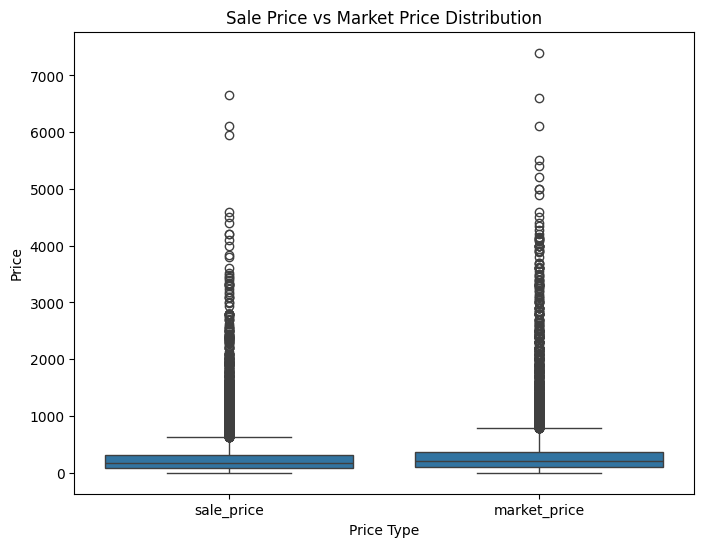

In [41]:
df_melted = df_train[['sale_price', 'market_price']].melt(var_name='Price Type', value_name='Price')
plt.figure(figsize=(8, 6))
sns.boxplot(x='Price Type', y='Price', data=df_melted)
plt.title('Sale Price vs Market Price Distribution')

In [42]:
df_train[['sale_price', 'market_price']].corr()

,sale_price,market_price
sale_price,1.000000,0.954524
market_price,0.954524,1.000000


As expected they are highly correlated. Also there seems to be a lot of outliers although 50% of products are in between 80 and 400

Now see if we are dealing with any missing values. Luckily the missing values are in product and description, which are features that eventually we will drop due to their irrelevance.

In [9]:
df_train.isnull().sum()

index            0
product          1
category         0
sub_category     0
brand            0
sale_price       0
market_price     0
type             0
rating           0
description     60
dtype: int64

Now lets observe the numerical values. sale price and market price seems to have a highly right skewed distribution. to normalize this behaviour we will transform the data logarithmically and then standar scale it.

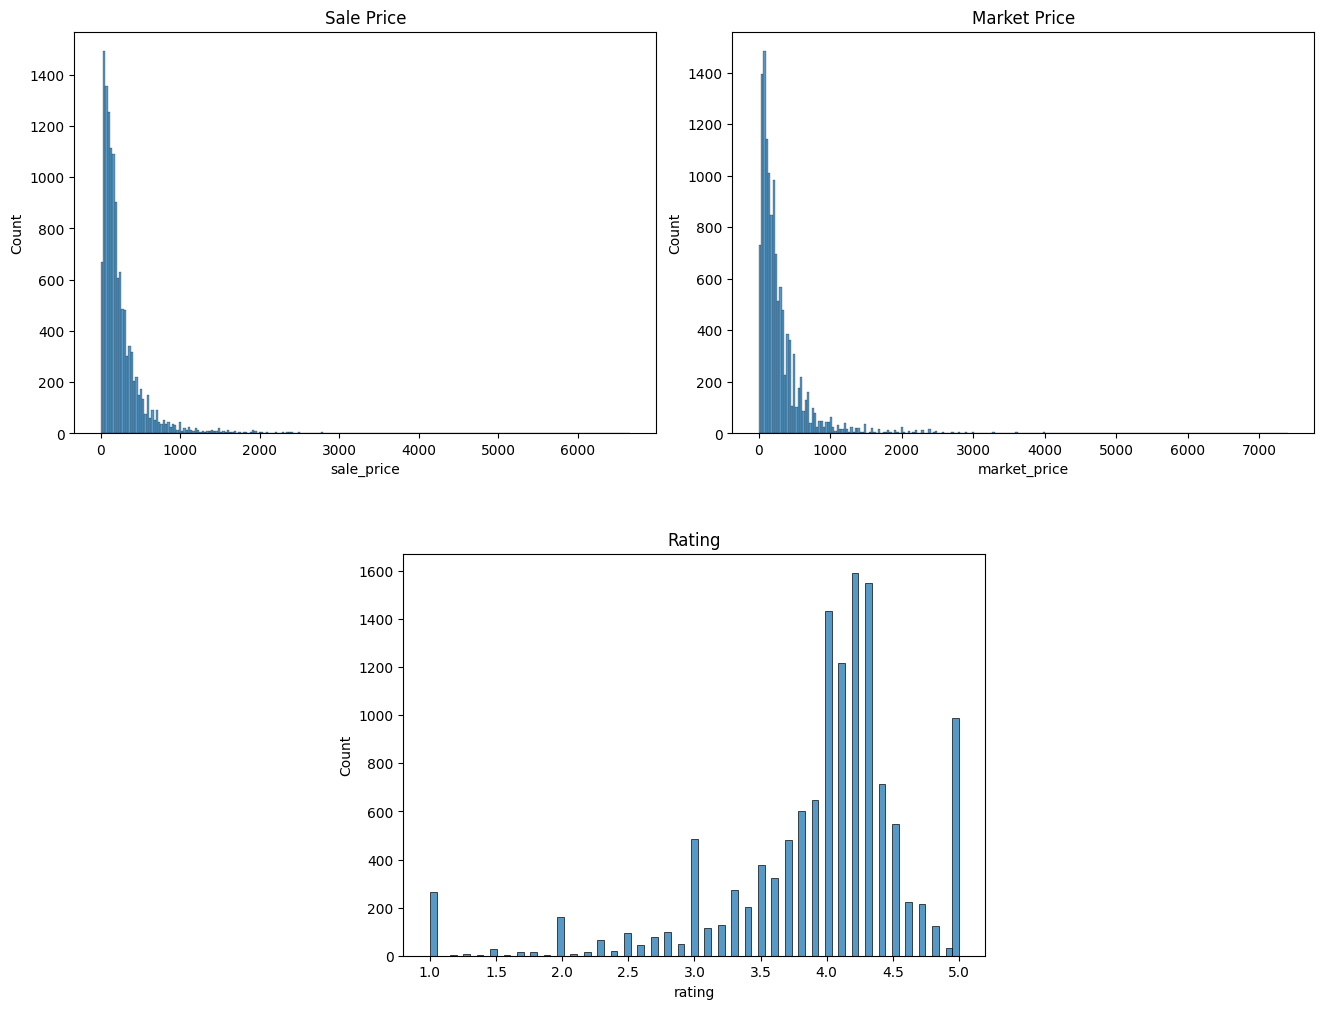

In [10]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0:2])
sns.histplot(df_train['sale_price'], ax=ax1)
ax1.set_title('Sale Price')

ax2 = fig.add_subplot(gs[0, 2:4])
sns.histplot(df_train['market_price'], ax=ax2)
ax2.set_title('Market Price')

ax3 = fig.add_subplot(gs[1, 1:3])
sns.histplot(df_train['rating'], ax=ax3)
ax3.set_title('Rating')

plt.show()

Now we examine the categorical values. See how many unique values are inside each feature.

In [23]:
df_train.select_dtypes(include=['object', 'category']).nunique()

product         11806
category            9
sub_category       76
brand            1762
type              353
description     11136
dtype: int64

The categorical values that have no relation with the target, I will be bold to guess, are product, type and description. Prouct is just the name of the product, type is something like a category and description is a long string describing the product. My guess is that people don't rate products in terms of these things. Category, sub-category and brand are features that could be interesting. 

## Preprocessing

For preprocessing I will make a pipeline. As mentioned before, the numerical features will be transformed by applying a logarithmic filter and then standardize scale them. The only categorical features that I am going to use are brand, sub-category and category. Category I am going to one hot encode (OHE) it since it is only 9 values. However since brand and subcategory have a lot of values I will target encode them, substituting their values for their mean in the rating. The preprocessor will be applied to the traing and testing dataset. It is important to distinguish between fit_transform (which requires the input and terget features) and transform, which only requires the input features of the test set.

In [56]:
# Define steps for numerical features
numeric_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

# Define steps for categorical features (Target Encoding)
categorical_transformer = TargetEncoder(smooth='auto') 

# Define steps for one-hot features
ohe_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['sale_price', 'market_price']),
        ('target_cat', categorical_transformer, ['brand', 'sub_category']),
        ('ohe_cat', ohe_transformer, ['category']) 
    ],
    remainder='drop'
)

# Now, apply to your data:
X_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train, y_train))
X_test_preprocessed = pd.DataFrame(preprocessor.transform(X_test))

## Base model (mean rating)

Before evaluating the model I will create a beseline model which is just the average raking of the train dataset

In [15]:
y_preds = np.full(shape=df_test['rating'].shape, fill_value=df_train['rating'].mean())
y_test = df_test['rating']

In [16]:
#metrics
mae_base = mean_absolute_error(y_test, y_preds)
mse_base = mean_squared_error(y_test, y_preds)
r2_base = r2_score(y_test, y_preds)
rmse_base = np.sqrt(mse_base)


## Linear regression

In [58]:
LinReg = LinearRegression()
LinReg.fit(X_train_preprocessed, y_train)

y_pred_train = LinReg.predict(X_train_preprocessed)
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_pred_test = LinReg.predict(X_test_preprocessed)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

In [59]:
# Model Comparison Summary Table
summary_data = {
    'Model': ['LinReg', 'LinReg','BaseModel'],
    'Dataset': ['Train', 'Test', 'Test'],
    'MSE': [mse_train, mse_test, mse_base],
    'MAE': [mae_train, mae_test, mae_base],
    'RMSE': [np.sqrt(mse_train), np.sqrt(mse_test), rmse_base],
    'R² Score': [r2_train, r2_test, r2_base]
}

summary_df = pd.DataFrame(summary_data)

print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)

MODEL PERFORMANCE SUMMARY
    Model Dataset      MSE      MAE     RMSE      R² Score
   LinReg   Train 0.496365 0.463320 0.704532  8.778605e-02
   LinReg    Test 0.505342 0.463783 0.710874  8.282445e-02
BaseModel    Test 0.550976 0.505593 0.742278 -3.229992e-07


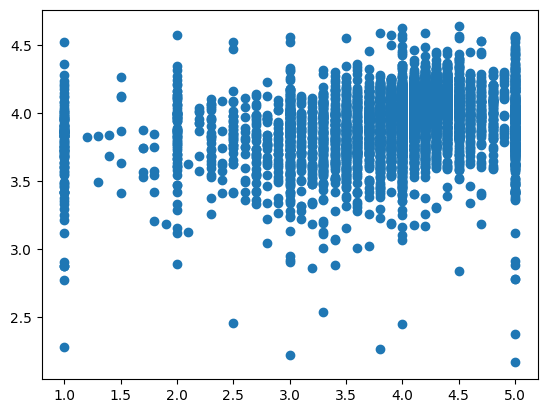

In [55]:
plt.plot(y_test, y_pred_test, 'o')

## Analysis and conclusions

The $R^2$ score is 0.08, almost zero, and from the previous plot we can see that there is barely any correlation at all, our model wasn't succesful to predict the rating. Now lets do some plots to figure out why.

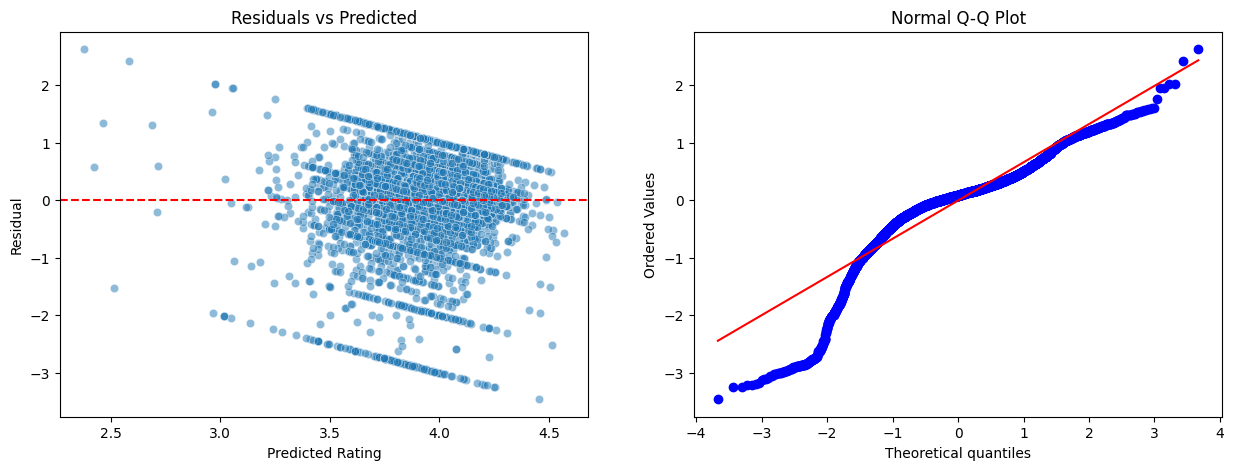

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

residuals = y_test - y_pred_test

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Residual Plot
sns.scatterplot(x=y_pred_test, y=residuals, ax=ax[0], alpha=0.5)
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_title('Residuals vs Predicted')
ax[0].set_xlabel('Predicted Rating')
ax[0].set_ylabel('Residual')

# Normality of Errors (Q-Q Plot)
stats.probplot(residuals, dist="norm", plot=ax[1])
ax[1].set_title('Normal Q-Q Plot')

plt.show()

count    13250.000000
mean         3.943283
std          0.737681
min          1.000000
25%          3.700000
50%          4.100000
75%          4.300000
max          5.000000
Name: rating, dtype: float64


<Axes: xlabel='rating', ylabel='Count'>

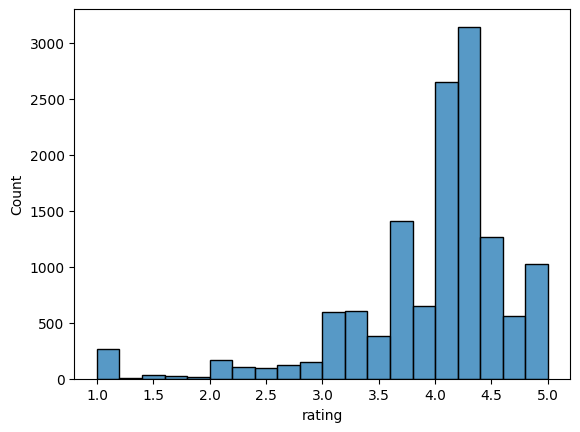

In [61]:
print(df_train['rating'].describe())
sns.histplot(df_train['rating'], bins=20)

Since the ratings are heavily stacked between 4.0 and 5.0, the model plays it safe by clustering almost all predictions in the narrow 3.5 to 4.5 range just to keep the global error as low as possible. Furthermore, the massive errors in the Q-Q plot show that the model is completely blind to what makes a product "bad"; it simply doesn't have the data—like poor build quality or bad shipping—needed to predict 1-star ratings, so it defaults to assuming everything will be average. This proves that price and category alone don't dictate user sentiment and that a linear approach is fundamentally the wrong tool for this non-linear, heavily skewed dataset.